In [8]:
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch
from torch import nn
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.nn import EdgeConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch_geometric.utils as Utils
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from scipy import linalg
import mplhep as hep
from numba import jit
#from models import GraphNet
plt.style.use(hep.style.CMS)

In [9]:
class GraphNet(nn.Module):
    def __init__(self, input_dim = 12, hidden_dim = 64, output_dim = 1, aggr = 'add', niters = 4):
        super(GraphNet, self).__init__()
        
        # transform to latent space
        self.inputnetwork = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ELU(),
#             nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(2*hidden_dim, hidden_dim),
#             nn.ReLU()
        )
        
        # to compute messages
        convnetwork = nn.Sequential(
            nn.Linear(2 * hidden_dim, 2 * hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(2 * hidden_dim, hidden_dim),
            nn.ReLU()
        )
        
        # EdgeConv
        self.graphconv = EdgeConv(nn=convnetwork, aggr=aggr)
        
        # edge features from node embeddings for classification
        self.edgenetwork = nn.Sequential(
            nn.Linear(2 * hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid()
        )
        
        self.niters = niters
    
    def forward(self, data):
        X = data.x
        #print(f"edges {data.num_edges}")
        #print(f"initial X size {X.size()}")
        H = self.inputnetwork(X)
        #print(f"size after inputnet {H.size()}")
        for i in range(self.niters):
            (prepared_edges, _) = Utils.add_self_loops(data.edge_index)
            H = self.graphconv(H, Utils.to_undirected(prepared_edges))
            #print(f"size of H after {i}th iter {H.size()}")
            
        src, dst = data.edge_index
        #print(f"src size {H[src].size()} dest size {H[dst].size()}")
        #print(f"torch cat {torch.cat([H[src], H[dst]], dim=-1).size()}")
        #print(f"GraphNet returns {self.edgenetwork(torch.cat([H[src], H[dst]], dim=-1)).squeeze(-1).size()}")
        #print(f"score size {(H[src] * H[dst]).sum(dim=-1)}")
        #return (H[src] * H[dst]).sum(dim=-1)
        return self.edgenetwork(torch.cat([H[src], H[dst]], dim=-1)).squeeze(-1)

In [10]:
def plotTrackster2D(fig, ax2, y, z, plot_missed=True, heatmap=None, indexes=None, edges=None, edges_t = None, label='Trackster Energy (GeV)', proj = None):
    fs = 16
    for ind in edges:
        if(ind not in edges_t):
            if len(ind) == 0:
                continue
#             for ied in ind:
            idx0 = ind[0]
            idx1 = ind[1]
            ax2.plot(
                [y[idx0] ,y[idx1]],
                [z[idx0] ,z[idx1]],
                'red', lw = 0.5, label = "Wrong Edges"
            )
        else:
            if len(ind) == 0:
                continue
#             for ied in ind:
            idx0 = ind[0]
            idx1 = ind[1]
            ax2.plot(
                [y[idx0], y[idx1]],
                [z[idx0] ,z[idx1]],
                'black', lw = 0.5, label = "Correct Edges"
            )
    if plot_missed:
        for t_ind in edges_t:
            if(t_ind not in edges):
                if len(t_ind) == 0:
                    continue
    #             for ied in ind:
                idx0 = t_ind[0]
                idx1 = t_ind[1]
                ax2.plot(
                    [y[idx0] ,y[idx1]],
                    [z[idx0] ,z[idx1]],
                    'blue', lw = 0.5, label = "Missed Edges"
                )
    yg = ax2.scatter(y, z, c=cm.viridis(heatmap/max(heatmap)), marker='o', linewidth=2)
    ax2.tick_params(axis='x', labelsize=fs )
    ax2.tick_params(axis='y', labelsize=fs )
    ax2.set_xlabel(proj[0] + " cm", fontsize = fs)
    ax2.set_ylabel(proj[1] + " cm", fontsize = fs)

In [11]:
  
def plotTrackster3D(fig, ax, x, y, z, plot_missed=True, heatmap=None, indexes=None, edges=None, edges_t = None, label='Trackster Energy (GeV)'):
    fs = 15
    print(x[0],y[0],z[0])
    ax.set_xlabel('Z (cm)', fontsize = fs)
    ax.set_ylabel('X (cm)', fontsize = fs)
    ax.set_zlabel('Y (cm)', fontsize = fs)
    colmap = cm.ScalarMappable(cmap=cm.viridis)
    if len(heatmap) > 0:
        for ind in edges:
            if(ind not in edges_t):
                if len(ind) == 0:
                    continue
    #             for ied in ind:
                idx0 = ind[0]
                idx1 = ind[1]
                ax.plot(
                    [x[idx0] ,x[idx1]],
                    [y[idx0] ,y[idx1]],
                    [z[idx0] ,z[idx1]],
                    'red', lw = 0.5, label = "Wrong Edges"
                )
            else:
                if len(ind) == 0:
                    continue
    #             for ied in ind:
                idx0 = ind[0]
                idx1 = ind[1]
                ax.plot(
                    [x[idx0] ,x[idx1]],
                    [y[idx0] ,y[idx1]],
                    [z[idx0] ,z[idx1]],
                    'black', lw = 0.5, label = "Correct Edges"
                )
        if plot_missed:
            for t_ind in edges_t:
                if(t_ind not in edges):
                    if len(t_ind) == 0:
                        continue
        #             for ied in ind:
                    idx0 = t_ind[0]
                    idx1 = t_ind[1]
                    ax.plot(
                        [x[idx0] ,x[idx1]],
                        [y[idx0] ,y[idx1]],
                        [z[idx0] ,z[idx1]],
                        'blue', lw = 0.5, label = "Missed Edges"
                    )
    if len(heatmap) > 0 :
        colmap.set_array(heatmap)
        yg = ax.scatter(x, y, z, c=cm.viridis(heatmap/max(heatmap)), marker='o', linewidth=2)
        cb = fig.colorbar(colmap,label=label)
    else:
        yg =ax.scatter(x, y, z, marker='o')     
    ax.tick_params(axis='x', labelsize=fs )
    ax.tick_params(axis='y', labelsize=fs )
    ax.tick_params(axis='z', labelsize=fs )



In [12]:
from matplotlib.lines import Line2D
def plotTrackster(fig, ax,ax2,ax3,ax4, x, y, z, plot_missed=True, heatmap=None, indexes=None, edges=None, edges_t = None, label='Trackster Energy (GeV)'):
    plotTrackster3D(fig, ax, x,y,z, plot_missed, heatmap=E,edges=p_pairs, edges_t = t_pairs )
    ## XY
    plotTrackster2D(fig, ax2 ,y, z, plot_missed, heatmap=E,edges=p_pairs, edges_t = t_pairs, proj=["X", "Y"])
    ## XZ
    plotTrackster2D(fig, ax3 ,y, x, plot_missed, heatmap=E,edges=p_pairs, edges_t = t_pairs, proj=["X", "Z"])
    ## YZ
    plotTrackster2D(fig, ax4 ,z, x, plot_missed, heatmap=E,edges=p_pairs, edges_t = t_pairs, proj=["Y", "Z"])
    custom_lines = [Line2D([0], [0], color='red',lw = 4),
                    Line2D([0], [0], color='black', lw=4),
                   Line2D([0], [0], color='blue', lw=4)]
    ax.legend(custom_lines, ['Wrong Edges', 'Correct Edges', "Missed Edges"], fontsize=15)

    plt.show()

In [13]:
# test dataset is not normalized before storing on disk
# as the mean_ and scale_ are required for the 
# inverse transformation
def normalize_and_get_data(data_list, ev):
    data_list_ev = data_list[ev]
    x_np = data_list_ev[0]
    x_coord_slice = x_np[:, [0,1,2]] # barycenter x, y, z
    x_rest_slice = x_np[:, [9,10,11]] # size, raw_e, raw_em_e
    
    mean = []
    std = []
    scaler=StandardScaler()
    scaler.fit(x_coord_slice)
    x_coord_norm = scaler.transform(x_coord_slice)
    mean.append(scaler.mean_)
    std.append(scaler.scale_)
    
    mean.append(np.zeros(6)) # for the unnormalized features
    std.append(np.ones(6))
    
    scaler.fit(x_rest_slice)
    x_rest_norm = scaler.transform(x_rest_slice)
    mean.append(scaler.mean_)
    std.append(scaler.scale_)
    
    mean = np.concatenate(mean, axis=-1)
    std = np.concatenate(std, axis=-1)
    
    x_ev = torch.from_numpy(np.concatenate((x_coord_norm, x_np[:,[3,4,5,6,7,8]], x_rest_norm), axis=1))
    edge_label = torch.from_numpy(data_list_ev[1])
    edge_index = torch.from_numpy(data_list_ev[2])
    data = Data(x=x_ev, num_nodes=torch.tensor(x_ev.shape[0]), edge_index=edge_index, edge_label=edge_label)
    return data, mean, std

# list of indices of best matched simts to all ts in an event
def get_truth_labels(data_list, ev):
    data_list_ev = data_list[ev]
    x_np = data_list_ev[0]
    x_best_simts = x_np[:, 12]
    return x_best_simts

# candidates containing the trackster
def get_cand_labels(data_list, ev):
    data_list_ev = data_list[ev]
    return data_list_ev[0][:, 13]

def truth_pairs(model, data_list, ev, thr=0.5):
    data_ev, mean, std = normalize_and_get_data(data_list, ev)
    truth_edge_index = data_ev.edge_index
    truth_edge_label = data_ev.edge_label > thr
    truth_nodes_features = torch.add(torch.mul(data_ev.x, torch.from_numpy(std)),torch.from_numpy(mean))
    
    src_edge_index_true = truth_edge_index[0][truth_edge_label]
    dest_edge_index_true = truth_edge_index[1][truth_edge_label]

    index_tuple = []
    for i in range(len(src_edge_index_true)):
        index_tuple.append([src_edge_index_true[i], dest_edge_index_true[i]])
    return truth_nodes_features, index_tuple

def prediction_pairs(model, data_list, ev, thr):
    data_ev, mean, std = normalize_and_get_data(data_list, ev)
    out = model(data_ev)
    truth_edge_index = data_ev.edge_index
    truth_edge_label = out > thr
    truth_nodes_features = torch.add(torch.mul(data_ev.x, torch.from_numpy(std)),torch.from_numpy(mean)) #denormalize
    
    src_edge_index_true = truth_edge_index[0][truth_edge_label]
    dest_edge_index_true = truth_edge_index[1][truth_edge_label]
    index_tuple = []
    for i in range(len(src_edge_index_true)):
        index_tuple.append([src_edge_index_true[i], dest_edge_index_true[i]])

    
    return truth_nodes_features,index_tuple 

def connectivity_matrix(model, data_list, ev, similarity=True, thr=0.6):
    data_ev, mean, std = normalize_and_get_data(data_list, ev)
    out = model(data_ev)
    N = data_ev.num_nodes
    mat = np.zeros([N, N])
    truth_mat = np.zeros([N, N])
    for indx, src in enumerate(data_ev.edge_index[0]):
        dest = data_ev.edge_index[1][indx]
        # weighted adj is filled only if score > thr
        if out[indx] > thr:
            mat[src][dest] = out[indx]
            mat[dest][src] = out[indx]
            
        truth_mat[src][dest] = data_ev.edge_label[indx]
        truth_mat[dest][src] = data_ev.edge_label[indx]
        
    if similarity == False:
        mat = mat > thr
    return mat, truth_mat

In [65]:
# Load the dataset
#testDataset = torch.load("/eos/user/w/wredjeb/SWAN_projects/GraphSC/HackathonLinking/dataProcessed/dataTest.pt")
#testDataset = torch.load("/eos/user/a/abhiriks/SWAN_projects/TICLv4graph/test/HackathonLinking/dataProcessed/dataTest.pt")
testDataset = torch.load("/eos/user/a/abhiriks/SWAN_projects/TICLv4graph/test/HackathonLinking/dataProcessed_improved/dataTest.pt")
#testDataset = torch.load("/eos/user/a/abhiriks/SWAN_projects/TICLv4graph/test/HackathonLinking/dataProcessed_multiParticle/dataTest.pt")

In [15]:
# Load the model
modelLoad = GraphNet()
#modelLoad.load_state_dict(torch.load("/eos/user/w/wredjeb/SWAN_projects/GraphSC/HackathonLinking/FirstModel/model.pt")["model_state_dict"])
modelLoad.load_state_dict(torch.load("/eos/user/a/abhiriks/SWAN_projects/TICLv4graph/test/HackathonLinking/model/trackster_graphconv_improved_truth.pt"))
modelLoad.eval()

GraphNet(
  (inputnetwork): Sequential(
    (0): Linear(in_features=12, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
  )
  (graphconv): EdgeConv(nn=Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
  ))
  (edgenetwork): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=64, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

345.18426337292397 -84.44280249373125 54.99285640896942


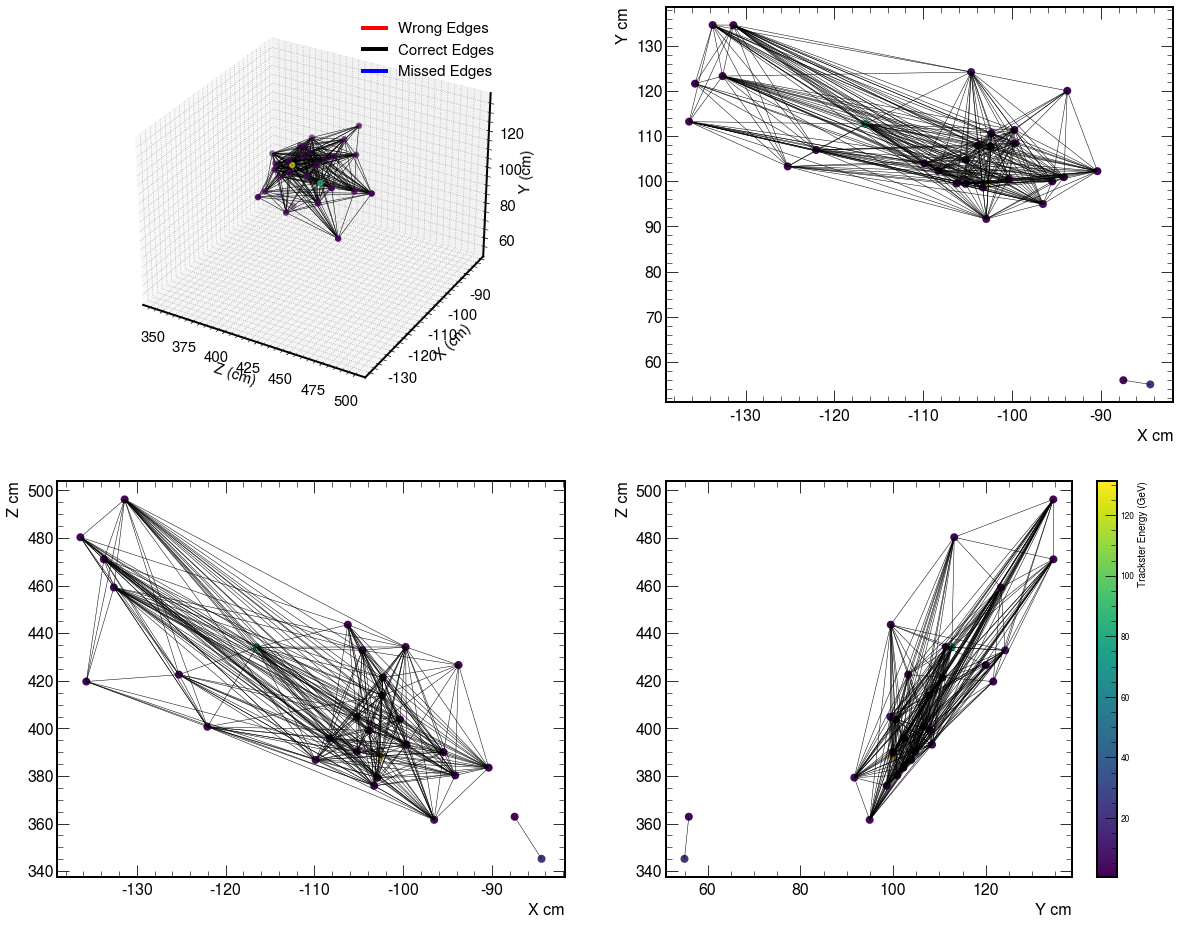

In [66]:
ev_vis = 6 #event to visualize
t_node, t_pairs = truth_pairs(modelLoad, testDataset, ev_vis, 0.5)
p_node, p_pairs = prediction_pairs(modelLoad, testDataset, ev_vis, 0.6)

from pylab import cm
from IPython.display import display

%matplotlib inline
fig = plt.figure(figsize=(20,16))
ax = fig.add_subplot(221, projection='3d')
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
x = p_node[:,0].detach().numpy()
y = p_node[:,1].detach().numpy()
z = p_node[:,2].detach().numpy()
E = p_node[:,10].detach().numpy()
plotTrackster(fig, ax, ax2,ax3 ,ax4 , z,x,y,plot_missed = True, heatmap=E, edges=p_pairs, edges_t = t_pairs)

In [67]:
# get the truth and predicted (weighted) adj matrices for the event
adj_weighted, truth_adj = connectivity_matrix(modelLoad, testDataset, ev_vis)
adj_unweigh = adj_weighted>0.6 # adj_unweigh is the thresholded matrix

degree_unweigh = np.sum(adj_unweigh, axis = 1)
degree_weighted = np.sum(adj_weighted, axis = 1)

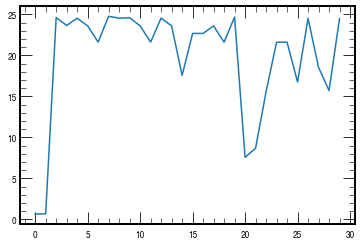

In [68]:
plt.plot(degree_weighted)

  The Laplacian can be: 
  
  Unnormalized $L = D - W$, $D$ is the degree and $W$ is the weighted adjacency matrix
  
  Normalized, $L_{rw} = D^{-1} L = \mathbb{1} - D^{-1} W$; $L$ is the unnormalized Laplacian 
 
  1: standard eigenvalue problem - $L u = \lambda u$, get first k eigenvaues, place them in an $N \times k$ matrix and cluster the rows
  
  2: generalized eigenvalue problem - $L u = \lambda D u$, and repeat the same steps as above

In [69]:
D_unweigh = np.diag(degree_unweigh)
D_weigh = np.diag(degree_weighted)

L = D_weigh - adj_weighted # Laplacian
print(f"Shape of the Laplacian {np.shape(L)}")

Shape of the Laplacian (30, 30)


In [70]:
n_eigvals = min(np.shape(L)[0]-2, 10)
try:
    eigvals_sorted, eigvecs_sorted = linalg.eigh(L, D_weigh, subset_by_index = [0, n_eigvals]) # linalg.eigh(L,b = D_weigh) for generalized eigenvalue problem
except linalg.LinAlgError:
    print("LinAlgError: falling back to using unnormalized Laplacian!")
    eigvals_sorted, eigvecs_sorted = linalg.eigh(L, subset_by_index = [0, n_eigvals])
    #eigvals_sorted, eigvecs_sorted = linalg.eigh(L_masked, D_masked, subset_by_index = [0, n_eigvals])

cluster_labels = np.where(eigvecs_sorted[1] < 0, 0, 1)
print(f"Fiedler vector : {eigvecs_sorted[1]}")
print(f"Clusters from Fiedler vector : {cluster_labels}")

Fiedler vector : [0.86329962 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
Clusters from Fiedler vector : [1 1 1 1 1 1 1 1 1 1 1]


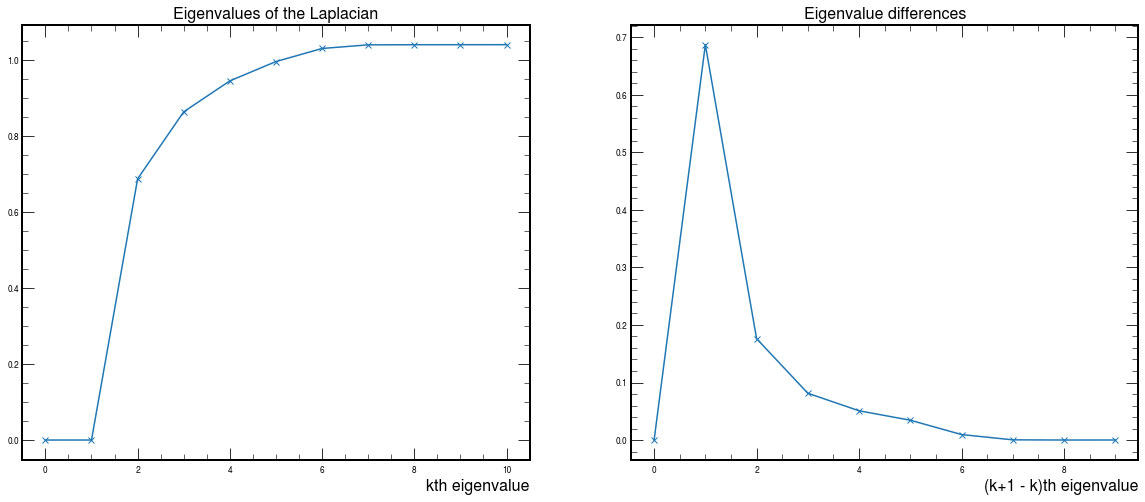

Eigenvalues : [-1.24268577e-16  5.89737428e-17  6.87235948e-01  8.63468882e-01
  9.44797322e-01  9.95644201e-01  1.03009343e+00  1.03961939e+00
  1.03994785e+00  1.03997351e+00  1.04003747e+00]


In [71]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(121)
ax.plot(eigvals_sorted, marker="x")
ax.set_xlabel("kth eigenvalue", fontsize = 16)
ax.set_title("Eigenvalues of the Laplacian", fontsize = 16)
ax = fig.add_subplot(122)
ax.plot(np.diff(eigvals_sorted), marker='x')
ax.set_xlabel("(k+1 - k)th eigenvalue", fontsize = 16)
ax.set_title("Eigenvalue differences", fontsize = 16)
plt.show()
print(f"Eigenvalues : {eigvals_sorted}")

In [72]:
# get the number of clusters from the eigenvalue spectrum

knee = 0
for i, d in enumerate(np.diff(eigvals_sorted)):
    if d > 0.2:
        knee = i
        if np.diff(eigvals_sorted)[i+1] > 3*d:
            knee = knee + 1
        break
print(f"Interesting eigengap between eigenvalues {knee+1} and {knee+2}")

n_clusters = knee + 1
print(f"Inferred {n_clusters} clusters")

Interesting eigengap between eigenvalues 2 and 3
Inferred 2 clusters


In [77]:
# Spectral clustering
from sklearn.cluster import SpectralClustering

sc = SpectralClustering(n_clusters = n_clusters, affinity = "precomputed", assign_labels="cluster_qr")
pred_cluster_labels = sc.fit_predict(adj_weighted)

print(f"predicted labels from spectral clustering : {pred_cluster_labels}")

num_pred_clusters = max(pred_cluster_labels)+1
predicted_clusters = [[] for i in range(num_pred_clusters)]

for i, label in enumerate(pred_cluster_labels):
    predicted_clusters[label].append(i)
print(f"predicted clusters : {predicted_clusters}")

predicted labels from spectral clustering : [0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
predicted clusters : [[0, 1], [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]]


/eos/user/a/abhiriks/.local/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [75]:
truth_cluster_labels = get_truth_labels(testDataset, ev_vis)
num_truth_clusters = int(max(truth_cluster_labels)+1)

truth_clusters = [[] for i in range(num_truth_clusters)]

for t, l in enumerate(truth_cluster_labels):
    truth_clusters[int(l)].append(t)

print(f"truth cluster labels : {truth_cluster_labels.astype(int)}")
print(f"truth clusters : {truth_clusters}")

truth cluster labels : [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
truth clusters : [[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], [0, 1]]


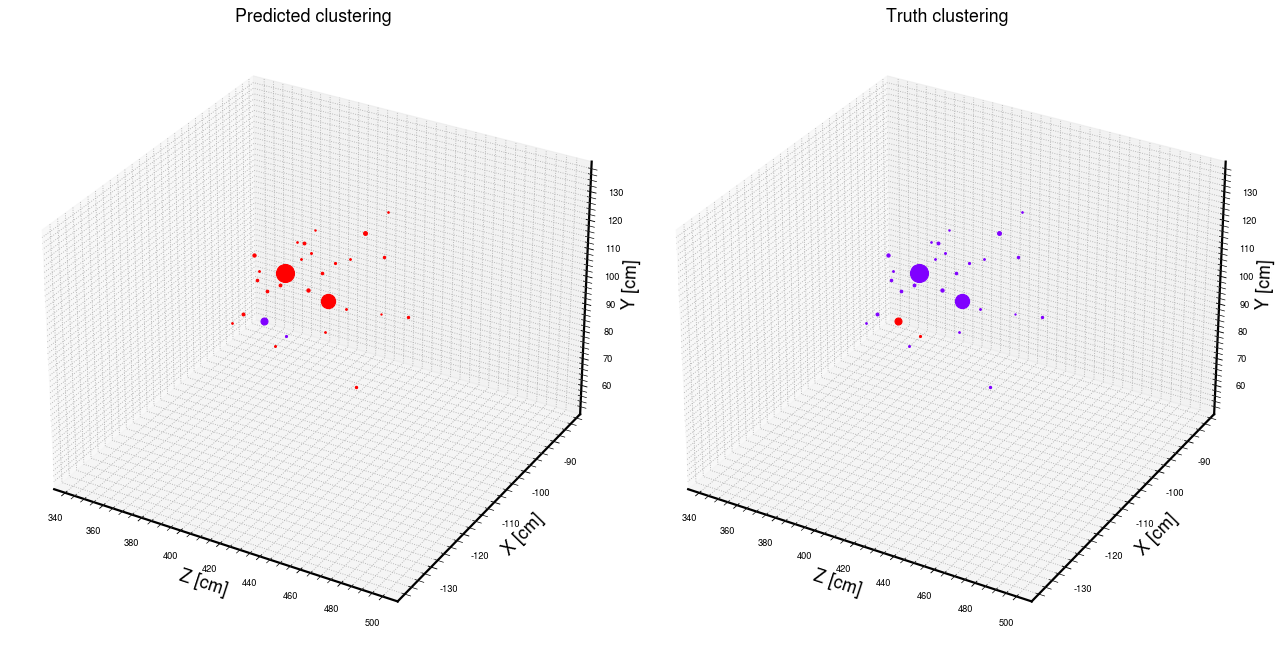

In [78]:
import matplotlib.colors
fig = plt.figure(figsize=(16,8), dpi=80)

# X-Y-Z
ax = fig.add_subplot(121, projection="3d")
ax.set_xlabel("Z [cm]", fontsize = 16)
ax.set_ylabel("X [cm]", fontsize = 16)
ax.set_zlabel("Y [cm]", fontsize = 16)
ax.set_title("Predicted clustering", fontsize = 16)
cmap = plt.cm.rainbow
norm_pred = matplotlib.colors.Normalize(0, max(pred_cluster_labels))
for i, x_i in enumerate(x):
    ax.scatter(z[i], x_i, y[i],s=E[i]*2, color=cmap(norm_pred(pred_cluster_labels[i])))
ax1 = fig.add_subplot(122, projection="3d")
ax1.set_xlabel("Z [cm]", fontsize = 16)
ax1.set_ylabel("X [cm]", fontsize = 16)
ax1.set_zlabel("Y [cm]", fontsize = 16)
ax1.set_title("Truth clustering", fontsize = 16)
cmap = plt.cm.rainbow
norm_truth = matplotlib.colors.Normalize(0, max(truth_cluster_labels))
for i, x_i in enumerate(x):
    ax1.scatter(z[i], x_i, y[i],s=E[i]*2, color=cmap(norm_truth(truth_cluster_labels[i])))
fig.tight_layout()

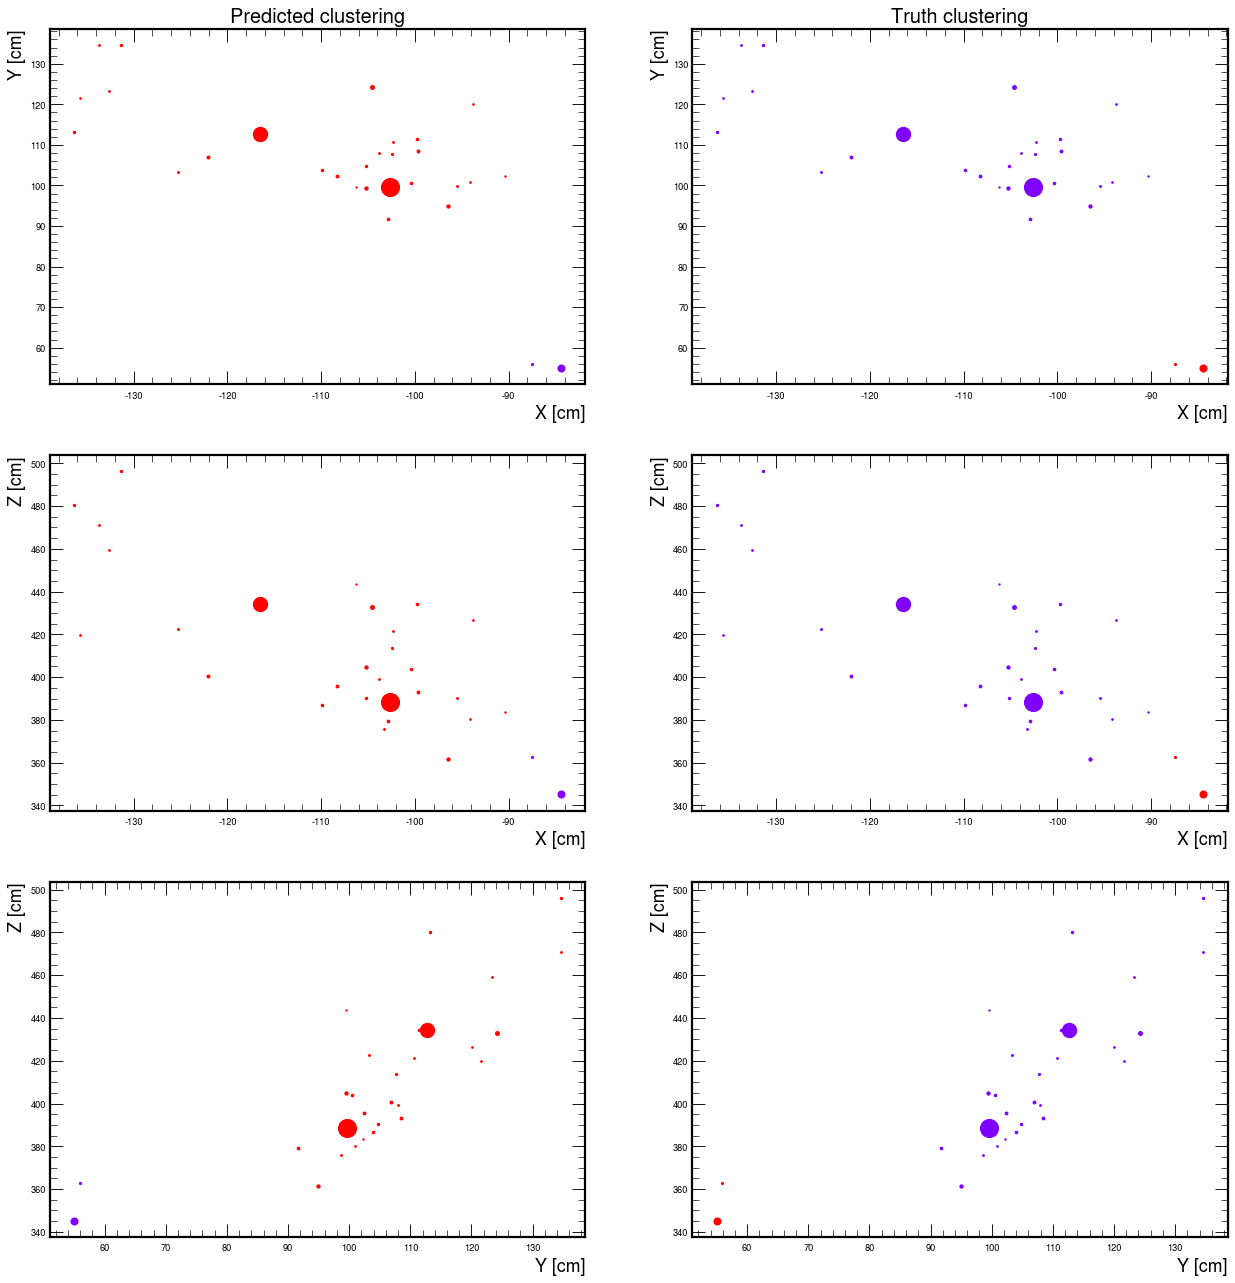

In [79]:
fig = plt.figure(figsize=(19,20), dpi=80)
# X-Y
ax = fig.add_subplot(321)
ax.set_xlabel("X [cm]", fontsize = 16)
ax.set_ylabel("Y [cm]", fontsize = 16)
ax.set_title("Predicted clustering", fontsize = 18)
ax1 = fig.add_subplot(322)
ax1.set_xlabel("X [cm]", fontsize = 16)
ax1.set_ylabel("Y [cm]", fontsize = 16)
ax1.set_title("Truth clustering", fontsize = 18)

for i, x_i in enumerate(x):
    ax.scatter(x_i, y[i],s=E[i]*2, color=cmap(norm_pred(pred_cluster_labels[i])))
    ax1.scatter(x_i, y[i],s=E[i]*2, color=cmap(norm_truth(truth_cluster_labels[i])))
    

# Z-X
ax = fig.add_subplot(323)
ax.set_xlabel("X [cm]", fontsize = 16)
ax.set_ylabel("Z [cm]", fontsize = 16)
ax1 = fig.add_subplot(324)
ax1.set_xlabel("X [cm]", fontsize = 16)
ax1.set_ylabel("Z [cm]", fontsize = 16)

for i, x_i in enumerate(x):
    ax.scatter(x_i, z[i],s=E[i]*2, color=cmap(norm_pred(pred_cluster_labels[i])))
    ax1.scatter(x_i, z[i],s=E[i]*2, color=cmap(norm_truth(truth_cluster_labels[i])))

    
    
# Z-Y
ax = fig.add_subplot(325)
ax.set_xlabel("Y [cm]", fontsize = 16)
ax.set_ylabel("Z [cm]", fontsize = 16)
ax1 = fig.add_subplot(326)
ax1.set_xlabel("Y [cm]", fontsize = 16)
ax1.set_ylabel("Z [cm]", fontsize = 16)

for i, x_i in enumerate(x):
    ax.scatter(y[i], z[i],s=E[i]*2, color=cmap(norm_pred(pred_cluster_labels[i])))
    ax1.scatter(y[i], z[i],s=E[i]*2, color=cmap(norm_truth(truth_cluster_labels[i])))


In [82]:
# Validation score between every "super trackster" and simtrackster
# a trackster is "in" it's best matched simtrackster
# Calculated as intersection / union; 1 = perfect match
# Intersection = sum(Energy of tracksters common)
# for every "super trackster" consider only the best score

    
#@jit
def scores_reco_to_sim(predicted_clusters, truth_cluster_labels, truth_cluster_energies, E):
    num_truth_clusters = int(max(truth_cluster_labels)+1)
    pred_cluster_energies = []
    reco_sim_scores = []
    best_sim_matches = []
    
    for pred_cluster in predicted_clusters:
        # for each predicted cluster, one score for every truth cluster
        scores_cluster = np.zeros(num_truth_clusters) # [0 for i in range(num_truth_clusters)]
        clusterE = 0
        for trackster in pred_cluster:
            truth_label = int(truth_cluster_labels[trackster])
            scores_cluster[truth_label] += E[trackster]
            clusterE += E[trackster]
        pred_cluster_energies.append(clusterE)
        
        for cluster in range(num_truth_clusters):
            scores_cluster[cluster] /= (pred_cluster_energies[-1] + truth_cluster_energies[cluster] - scores_cluster[cluster])
        reco_sim_scores.append(np.max(scores_cluster))
        best_sim_matches.append(np.argmax(scores_cluster))
        
    return reco_sim_scores, best_sim_matches, pred_cluster_energies


truth_cluster_energies = []
for t_cluster in truth_clusters:
    clusterE = 0
    for t in t_cluster:
        clusterE += E[t]
    truth_cluster_energies.append(clusterE)

reco_sim_scores, best_sim_matches, pred_cluster_energies = scores_reco_to_sim(predicted_clusters, truth_cluster_labels, truth_cluster_energies, E)

print(f"RECO-SIM scores : {reco_sim_scores}")
print(f"Best SIM matches : {best_sim_matches}")
print(f"\nPredicted cluster energies (GeV) : {pred_cluster_energies}")
print(f"Truth cluster energies (GeV) : {truth_cluster_energies}")

RECO-SIM scores : [1.0, 1.0]
Best SIM matches : [1, 0]

Predicted cluster energies (GeV) : [21.171058361077403, 266.8720925788696]
Truth cluster energies (GeV) : [266.8720925788696, 21.171058361077403]


In [83]:
# baseline scores of TICLCandidates
cluster_labels_candidate = get_cand_labels(testDataset, ev_vis)
clusters_candidate = [[] for i in range(int(max(cluster_labels_candidate))+1)]
for ts, cand in enumerate(cluster_labels_candidate):
    clusters_candidate[int(cand)].append(ts)

print(f"Clusters from TICLCandiate: {clusters_candidate}")    

cand_sim_scores, cand_best_sim_matches, cand_energies = scores_reco_to_sim(clusters_candidate, truth_cluster_labels, truth_cluster_energies, E)
print(f"\nTICLCandidate - SIM scores : {cand_sim_scores}")
print(f"Best SIM matches : {cand_best_sim_matches}")
print(f"Candidate energies : {cand_energies}")

Clusters from TICLCandiate: [[0, 1], [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 23, 24, 26, 27, 28, 29], [22], [20], [21], [25]]

TICLCandidate - SIM scores : [1.0, 0.9855593885522378, 0.004958769893011805, 0.003762840685593969, 0.003564606464879701, 0.0021543944042769297]
Best SIM matches : [1, 0, 0, 0, 0, 0]
Candidate energies : [21.171058361077403, 263.0182963836869, 1.323357297965158, 1.004197167805371, 0.9512939865026127, 0.5749477429095915]


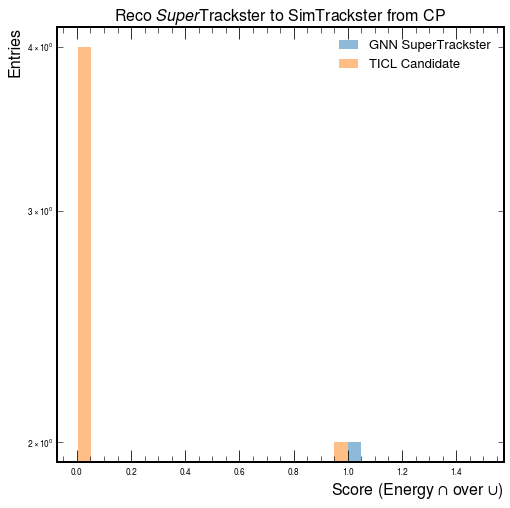

In [84]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot()
ax.hist(reco_sim_scores, alpha=0.5, bins=20, label="GNN SuperTrackster")
ax.hist(cand_sim_scores, alpha=0.5, bins=20, label="TICL Candidate")
ax.set_xlabel(r"Score (Energy $\cap$ over $\cup$)", fontsize=16)
ax.set_ylabel(r"Entries", fontsize=16)
ax.set_title(r"Reco $\it{Super}$Trackster to SimTrackster from CP", fontsize=16)
plt.yscale("log")
plt.legend(fontsize=13)
plt.show()
#plt.savefig("scores_histogram.png")

(0.0, 1.0)

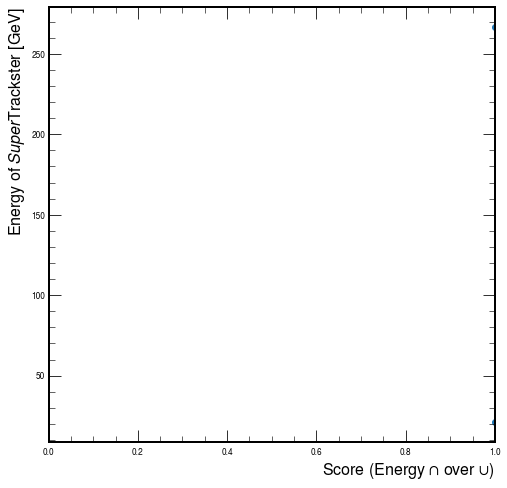

In [85]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()
ax.scatter(reco_sim_scores, pred_cluster_energies, marker="o")
ax.set_xlabel(r"Score (Energy $\cap$ over $\cup$)", fontsize=16)
ax.set_ylabel("Energy of $\it{Super}$Trackster [GeV]", fontsize=16)
ax.set_xlim([0.,1.])
#plt.savefig("EnergyVsScore.png")

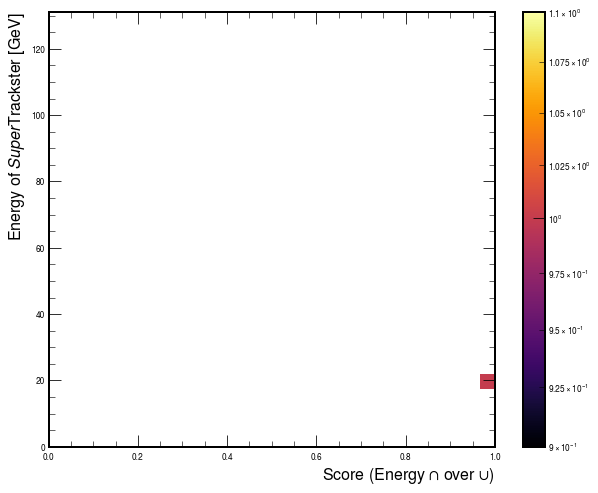

In [86]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()
h = ax.hist2d(reco_sim_scores, pred_cluster_energies, bins = 30, norm=matplotlib.colors.LogNorm(), cmap=cm.inferno, range = [[0., 1.],[0, max(E)]])
ax.set_xlabel(r"Score (Energy $\cap$ over $\cup$)", fontsize=16)
ax.set_ylabel("Energy of $\it{Super}$Trackster [GeV]", fontsize=16)
fig.colorbar(h[3], ax=ax)
plt.show()